# Density Estimation: Gaussian Mixture Models

- *Jake VanderPlas*
- *ESAC statistics workshop, Oct 27-31 2014*
- *Source available on [github](http://github.com/jakevdp/ESAC-stats-2014)*

Here we'll explore **K Means Clustering**, which is an unsupervised clustering technique.

We'll start with our standard set of initial imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
# If this causes an error, you can comment it out.
import seaborn as sns
sns.set()

## Introducing Gaussian Mixture Models

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.

For example, imagine we have some one-dimensional data in a particular distribution:

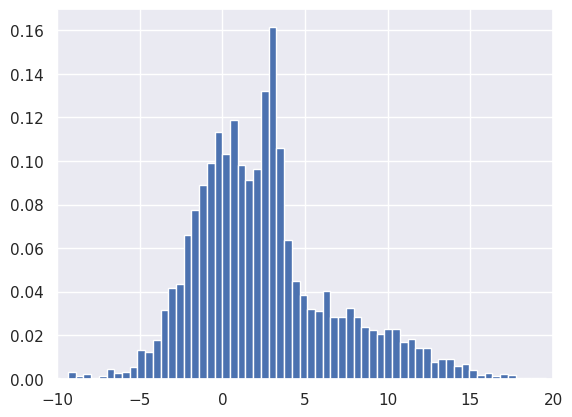

In [64]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, density=True)
plt.xlim(-10, 20);


Gaussian mixture models will allow us to approximate this density:

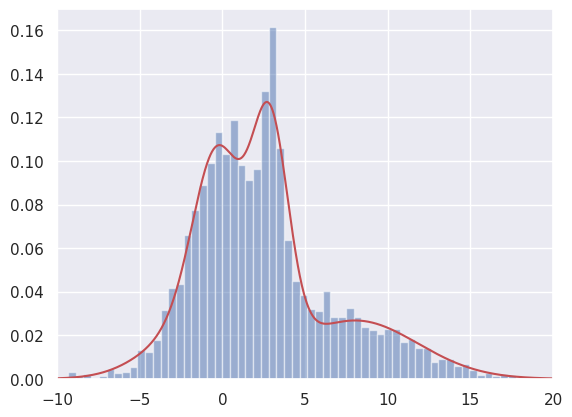

In [21]:
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(4, max_iter=500, random_state=3).fit(x.reshape(-1,1))
xpdf = np.linspace(-10, 20, 1000)#.reshape(-1,1)
density = np.exp(clf.score_samples(xpdf.reshape(-1,1)))

plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [22]:
clf.means_

array([[ 8.04894855],
       [-0.26509542],
       [ 2.87628921],
       [-1.762037  ]])

In [27]:
clf.covariances_

array([[[14.2611261 ]],

       [[ 2.1852085 ]],

       [[ 1.25253655]],

       [[ 7.39304484]]])

In [24]:
clf.weights_

array([0.2532411 , 0.31029078, 0.28492403, 0.15154409])

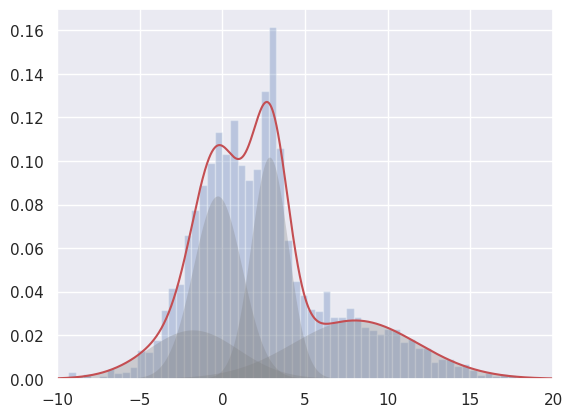

In [28]:
plt.hist(x, 80, density=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

In [30]:
print(clf.bic(x.reshape(-1,1)))
print(clf.aic(x.reshape(-1,1)))

25825.2019102245
25754.42998281725


Let's take a look at these as a function of the number of gaussians:

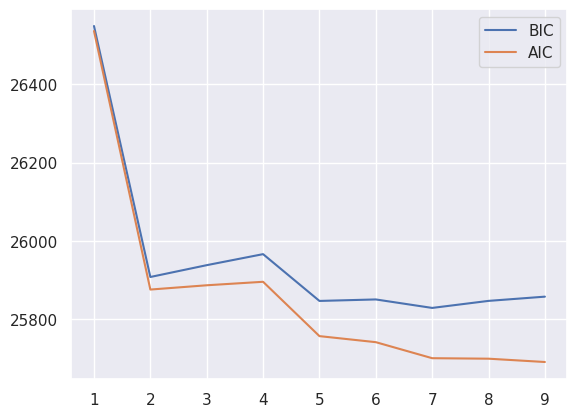

In [34]:
n_estimators = np.arange(1, 10)
clfs = [GaussianMixture(n, max_iter=1000).fit(x.reshape(-1,1)) for n in n_estimators]
bics = [clf.bic(x.reshape(-1,1)) for clf in clfs]
aics = [clf.aic(x.reshape(-1,1)) for clf in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

It appears that for both the AIC and BIC, 4 components is preferred.

## GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.
One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [39]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

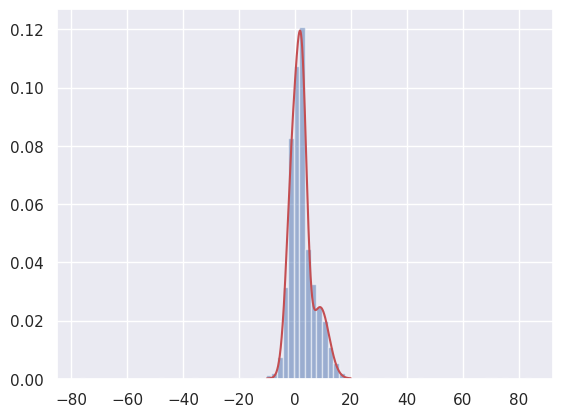

In [46]:
clf = GaussianMixture(4, max_iter=500, random_state=0).fit(y.reshape(-1,1))
xpdf = np.linspace(-10, 20, 1000).reshape(-1,1)
density_noise = np.exp(clf.score_samples(xpdf))#.reshape(-1,1)))

plt.hist(y, 80, density=True, alpha=0.5)
plt.plot(xpdf[:,0], density_noise, '-r')
#plt.xlim(-10, 20);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

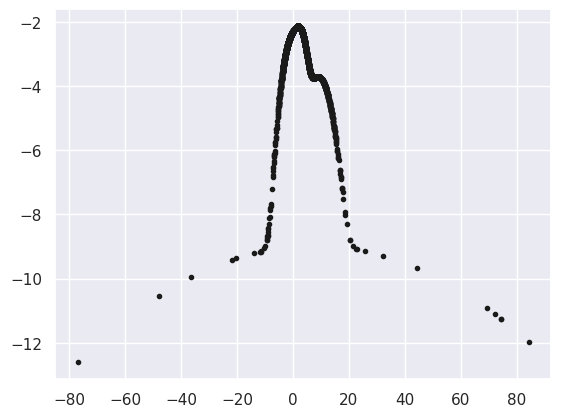

In [53]:
log_likelihood = clf.score_samples(y.reshape(-1,1))#[0]
plt.plot(y, log_likelihood, '.k');

In [76]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2130 2135 2163 2222 2496 2724 2732 2893 2897
 3067 3173 3253 3468 3483 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [77]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers:

In [78]:
set(detected_outliers) - set(true_outliers)

{2130, 2724, 3067, 3173, 3253, 3483}

Finally, we should note that although all of the above is done in one dimension, GMM does generalize to multiple dimensions, as we'll see in the breakout session.

## Other Density Estimators

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of *every* training point!

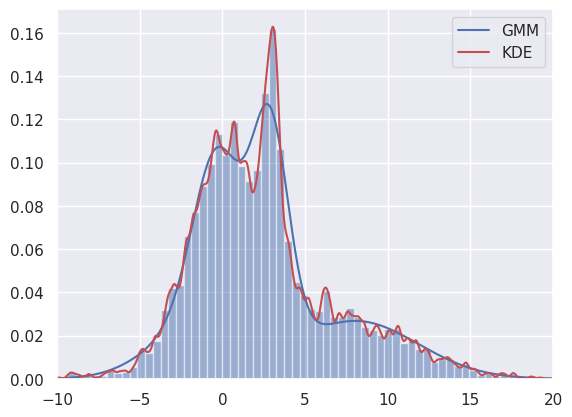

In [79]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf))

plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();